### Изучение поведения пользователей мобильного приложения продажи продуктов

В стартапе, который продаёт продукты питания, нужно разобраться, как ведут себя пользователи мобильного приложения. 
В проекте необходимо:
1. Изучить воронку продаж. Узнайть, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?
2. Исследовать результаты A/A/B-эксперимента по изменению шрифтов во всём приложении. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми.

#### Описание данных.

Каждая запись в логе — это действие пользователя, или событие. 
- EventName — название события;
- DeviceIDHash — уникальный идентификатор пользователя;
- EventTimestamp — время события;
- ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

#### Изучение и предобработка исходных данных

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import math as mth
from datetime import date, datetime, timedelta
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go
pd.options.display.max_colwidth = 150

In [2]:
pip install -U kaleido

In [3]:
data = pd.read_csv('/Users/HP/Downloads/logs_exp.csv', sep='\t')

data.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


Изменим названия столбцов на более удобные.

In [4]:
data.columns = ['event_type', 'user_id', 'datetime', 'group']

Проверим типы данных.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   event_type  244126 non-null  object
 1   user_id     244126 non-null  int64 
 2   datetime    244126 non-null  int64 
 3   group       244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Проверим пропуски.

In [6]:
data.isna().sum()

event_type    0
user_id       0
datetime      0
group         0
dtype: int64

Пропуски в данных отсутвуют. Проверим на явные дубликаты.

In [7]:
print('Количество явных дубликатов: ', data.duplicated().sum())
print('Доля явных дубликатов: ', round(data.duplicated().sum()*100/data['user_id'].count(), 2), '%')

Количество явных дубликатов:  413
Доля явных дубликатов:  0.17 %


Доля явных дубликатов 0.17 %. Удалим их.

In [8]:
data = data.drop_duplicates().reset_index(drop=True)

Проверим явные дубликаты еще раз.

In [9]:
print('Количество явных дубликатов в orders: ', data.duplicated().sum())

Количество явных дубликатов в orders:  0


Добавим столбец даты и времени, а также отдельный столбец дат.

In [10]:
data['datetime'] = pd.to_datetime(data['datetime'], unit='s')
data['date'] = (data['datetime']).dt.date
data['date'] = pd.to_datetime(data['date'])

Еще раз проверим типы данных.

In [11]:
data.head()

,event_type,user_id,datetime,group,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_type  243713 non-null  object        
 1   user_id     243713 non-null  int64         
 2   datetime    243713 non-null  datetime64[ns]
 3   group       243713 non-null  int64         
 4   date        243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 9.3+ MB


Проверим есть ли пересечение пользователей в группах.

In [13]:
data.groupby('user_id').agg({'group':'nunique'}).value_counts()

group
1        7551
dtype: int64

Пересечения пользователей в группах отсутствует.

#### Вывод

В данном разделе познакомились с данными, изменили название столбцов на более удобные, проверили на пропуски, удалили явные дубликаты и преобразорвали данные о дате. Также проверили отсутствие пересечения пользователей в группах.

#### Проверка данных

In [14]:
print('Количество событий в логе: ', data['event_type'].count())
print('Количество пользователей в логе: ', data['user_id'].nunique())

Количество событий в логе:  243713
Количество пользователей в логе:  7551


Посчитаем среднее количество событий на пользователя.

In [15]:
data.groupby('user_id').agg({'event_type':'count'}).median()

event_type    20.0
dtype: float64

Определим данными за какой период располагаем.

In [16]:
print('Минимальная дата:', data['date'].min())
print('Максимальная дата:', data['date'].max())

Минимальная дата: 2019-07-25 00:00:00
Максимальная дата: 2019-08-07 00:00:00


Определим насколько полные данные во всем периоде.

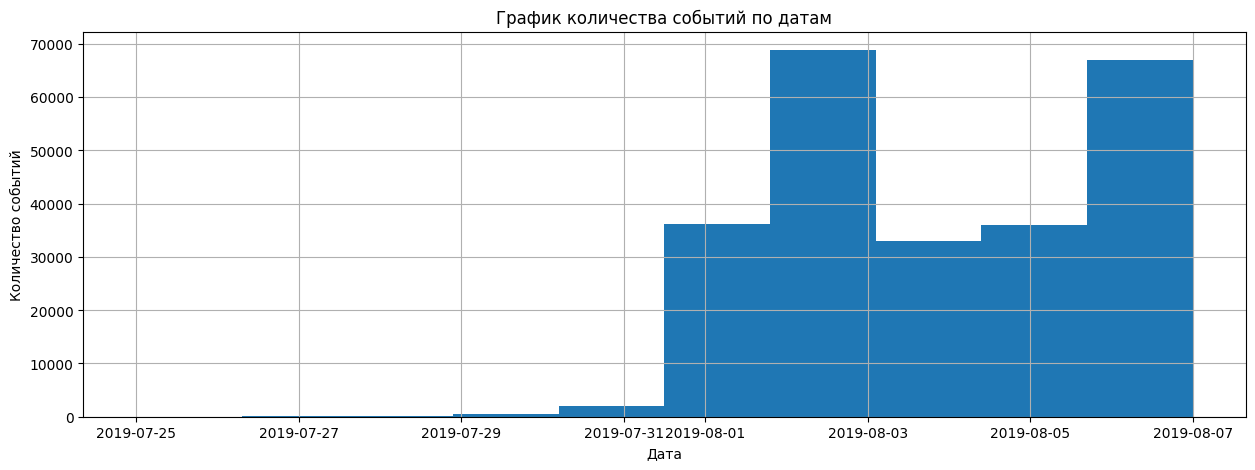

In [17]:
data.hist('date', figsize=(15,5))
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.title('График количества событий по датам')
plt.show()

По гистаграмме видно, что полные данные есть только за период с 2019-08-01 по 2019-08-07.

Сделаем срез данных по дате 2019-08-01.

In [18]:
data_new = data.query('date > "2019-07-31"')

Посчитаем количество событий и пользователей в логе за новый актуальный период и какой процент данных потеряли.

In [19]:
print('Количество событий в логе: ', data_new['event_type'].count())
print('Количество пользователей в логе: ', data_new['user_id'].nunique())
print('Какой % событий потеряли: ', round(100-data_new['event_type'].count()*100/data['event_type'].count(), 2))
print('Какой % пользователей потеряли: ', round(100-data_new['user_id'].nunique()*100/data['user_id'].nunique(), 2))

Количество событий в логе:  240887
Количество пользователей в логе:  7534
Какой % событий потеряли:  1.16
Какой % пользователей потеряли:  0.23


Посчитаем новое среднее количество событий на пользователя.

In [20]:
data_new.groupby('user_id').agg({'event_type':'count'}).median()

event_type    19.0
dtype: float64

Проверим пользователи из каких групп у нас остались.

In [21]:
data_new.groupby('group').agg({'user_id':'nunique'})

,user_id
group,
246,2484
247,2513
248,2537


#### Вывод

Изначально лог содеражал данные за период с 2019-07-25 по 2019-08-07. В ходе анализа установлено, что полные данные есть только за период с 2019-08-01 по 2019-08-07. Данные за этот период мы и будем рассматривать в дальнейшем. В логе за актуальный период 7534 пользователя и 240887 событий. Среднее количество событий на пользователя - 19. При срезе данных по дате потеряно меньше 1% пользователей и 1% событий. В рассматриваемом периоде пользователи распределены по экспериментальным группам примерно в равном количестве.

#### Изучение воронки событий

Посмотрим, какие события есть в логах и как часто они встречаются.

In [22]:
data_new['event_type'].value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_type, dtype: int64

Посчитаем сколько пользователей совершали каждое из этих событий и долю пользователей, которые хоть раз совершали событие.

In [23]:
events = data_new.groupby('event_type').agg({'user_id':'nunique'}).sort_values(by='user_id', ascending=False).reset_index()

users_id_count = 7534 # всего пользователей в логе
events['user_id %'] = round(events['user_id']*100/users_id_count, 2)
events

,event_type,user_id,user_id %
0,MainScreenAppear,7419,98.47
1,OffersScreenAppear,4593,60.96
2,CartScreenAppear,3734,49.56
3,PaymentScreenSuccessful,3539,46.97
4,Tutorial,840,11.15


Предположим, что события, совершаемые пользователем, происходят в следующем порядке:                                                                     
1. Открывает главную страницу (MainScreenAppear).
2. Открывает страницу определенного продукта (OffersScreenAppear).
3. Переходит в корзину с товарами (CartScreenAppear).
4. Оплачивает выбранные товары (PaymentScreenSuccessful).

Событие "руководство" (Tutorial) не входит в воронку.

Посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем).

In [24]:
events = events.query('event_type != "Tutorial"')
events['funnel %'] = round(events['user_id']*100/events['user_id'].shift(1), 2)
events

C:\Users\HP\AppData\Local\Temp\ipykernel_14736\3672370076.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events['funnel %'] = round(events['user_id']*100/events['user_id'].shift(1), 2)


,event_type,user_id,user_id %,funnel %
0,MainScreenAppear,7419,98.47,NaN
1,OffersScreenAppear,4593,60.96,61.91
2,CartScreenAppear,3734,49.56,81.30
3,PaymentScreenSuccessful,3539,46.97,94.78


Построим график воронки событий.

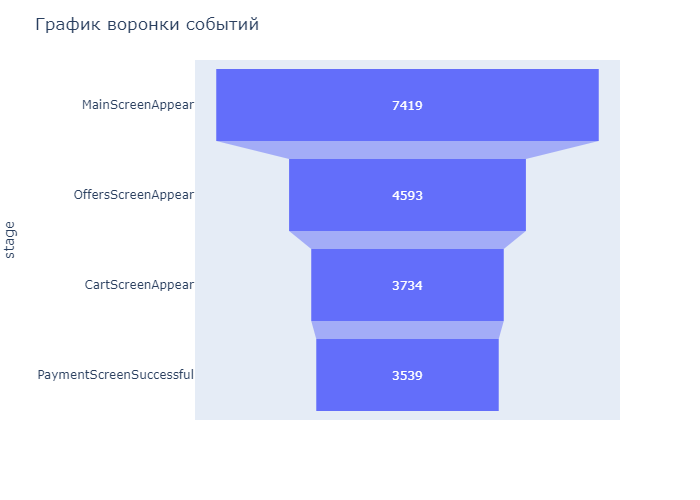

In [25]:
df = dict(
    number=events['user_id'],
    stage=events['event_type'])
fig = px.funnel(df, x='number', y='stage')
fig.update_layout(title="График воронки событий")
fig.show("png")

Больше всего (40 %) пользователей теряется при переходе с главной страницы на страницу продукта.

Посчитаем, какая доля пользователей доходит от первого события до оплаты.

In [26]:
events.iloc[-1]['user_id']/events.iloc[0]['user_id']

0.47701846610055265

От просмотра главной страницы до этапа оплаты доходит 47,7 % пользователей.

#### Вывод

На данном этапе изучена воронка событий. Выявлено, что в логе 4 основных события и одно, не входящее в воронку событий. Больше всего (40 %) пользователей теряется при переходе с главной страницы на страницу продукта. Это может быть связано с тем, что пользователь добавляет заказ в корзину сразу с главной страницы. От просмотра главной страницы до этапа оплаты доходит 47,7 % пользователей.

#### Изучение результатов эксперимента

Посмотрим сколько пользователей в каждой экспериментальной группе.

In [27]:
groups = data_new.groupby('group').agg({'user_id':'nunique'})
groups

,user_id
group,
246,2484
247,2513
248,2537


Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверим, находят ли статистические критерии разницу между выборками 246 и 247.

Посмотрим сколько пользователей совершали каждое из событий с разбивкой по группам.

In [28]:
events_groups = (
    data_new.pivot_table(index='event_type',columns='group',values='user_id',aggfunc='nunique')
    .sort_values(by=246,ascending=False).reset_index()
)

events_groups

group,event_type,246,247,248
0,MainScreenAppear,2450,2476,2493
1,OffersScreenAppear,1542,1520,1531
2,CartScreenAppear,1266,1238,1230
3,PaymentScreenSuccessful,1200,1158,1181
4,Tutorial,278,283,279


In [29]:
n_users = {'all': data_new['user_id'].nunique(), 
           246: data_new[data_new['group']==246]['user_id'].nunique(),
           247: data_new[data_new['group']==247]['user_id'].nunique(),
           248: data_new[data_new['group']==248]['user_id'].nunique(),
           '246+247': data_new[(data_new['group']==246) | (data_new['group']==247)]['user_id'].nunique()}
n_users

{'all': 7534, 246: 2484, 247: 2513, 248: 2537, '246+247': 4997}

Сформулируем гипотезы. Нулевая: между долями нет значимой разницы. Альтернативная: между долями есть значимая разница.

Напишем функцию для проверки гипотез. Для снижения вероятности ложнопозитивного результата при множественном тестировании гипотез скорректируем стандартный уровень значимости, равный 0.05, применив поправку Шидака.

In [30]:
def z_value(first_group, second_group, alpha):
    for i in events_groups.index:
        alpha = alpha
        p1 = events_groups[first_group][i] /n_users[first_group]
        # пропорция успехов во второй группе:
        p2 = events_groups[second_group][i] /n_users[second_group]
        # пропорция успехов в комбинированном датасете:
        p_combined = ((events_groups[first_group][i] + events_groups[second_group][i]) / 
                      (n_users[first_group] + n_users[second_group]))
        # разница пропорций в датасетах
        difference = p1 - p2
        # считаем статистику в ст.отклонениях стандартного нормального распределения
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * 
                                        (1/n_users[first_group] + 1/n_users[second_group]))
        # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
        distr = st.norm(0, 1) 
        p_value = (1 - distr.cdf(abs(z_value))) * 2
        # применяем метод Шидака
        shidak_alpha = 1 - (1-alpha)**(1/20)
        print('{} p-значение: {}'.format(events_groups['event_type'][i], p_value))
        if (p_value < shidak_alpha):
            print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
        else:
            print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")
        print('')

Посмотрим какой уровень значимости получился при применении метода Шидака.

In [31]:
print('Уровень значимости по методу Шидака:', round(1 - (1-0.05)**(1/20), 4))

Уровень значимости по методу Шидака: 0.0026


Сравним группы 246 и 247.

In [32]:
z_value(246,247,0.05)

MainScreenAppear p-значение: 0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Tutorial p-значение: 0.9376996189257114
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Проверка по всем событиях показала, что нет оснований считать доли разными. Можно сказать, что разбиение на группы работает корректно.

Аналогично поступим с группой с изменённым шрифтом. Сравним результаты с каждой из контрольных групп в отдельности по каждому событию.

Сравним группы 246 и 248.

In [33]:
z_value(246,248,0.05)

MainScreenAppear p-значение: 0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Tutorial p-значение: 0.8264294010087645
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Между группами 246 и 248 значимой разницы также нет.

Сравним группы 247 и 248.

In [34]:
z_value(247,248,0.05)

MainScreenAppear p-значение: 0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Tutorial p-значение: 0.765323922474501
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Между группами 247 и 248 значимой разницы также нет.

Сравним результаты с объединённой контрольной группой.

In [35]:
events_groups['246+247'] = events_groups[246] + events_groups[247]

z_value('246+247',248,0.05)

MainScreenAppear p-значение: 0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Tutorial p-значение: 0.764862472531507
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Между объединенной контрольной группой и экспериментальной значимой разницы также нет.

#### Вывод

В данном разделе мы выполнили 20 проверок гипотез: 5 проверок между контрольными группами и 15 между контрольными группами и экспериментальной группой. Для снижения вероятности ложнопозитивного результата при множественном тестировании гипотез стандартный уровень значимости, равный 0.05, был скорректирован методом Шидака и составил 0.0026. Все 20 проверок показали, что значимой разницы между группами нет. 

Если бы мы применили уровень значимости 0.1, то только одна проверка (группы 246 и 248, событие CartScreenAppear) показала бы значимую разницу между группами. Учитывая, что при уровне значимости 0.1 каждый десятый раз можно получать ложный результат, стоит применять уровень значимости, скорректированный методом Шидака.

#### Общий вывод

Целью данного проекта являлось изучение поведения пользователей мобильного приложения продажи продуктов питания, а также исследование результатов A/A/B-эксперимента по изменению шрифтов во всём приложении. 

Изначально лог содеражал данные за период с 2019-07-25 по 2019-08-07. В ходе анализа установлено, что полные данные есть только за период с 2019-08-01 по 2019-08-07. Данные за этот период были рассмотрены в проекте. В логе за актуальный период 7534 пользователя и 240887 событий. Среднее количество событий на пользователя - 19. При срезе данных по дате потеряно меньше 1% пользователей и 1% событий. В рассматриваемом периоде пользователи распределены по экспериментальным группам примерно в равном количестве.

В ходе изучения воронки событий выявлено, что в логе 4 основных события и одно, не входящее в воронку событий. Больше всего (40 %) пользователей теряется при переходе с главной страницы на страницу продукта. Это может быть связано с тем, что пользователь добавляет заказ в корзину сразу с главной страницы. От просмотра главной страницы до этапа оплаты доходит 47,7 % пользователей.

При исследовании результатов A/A/B-эксперимента мы выполнили 20 проверок гипотез: 5 проверок между контрольными группами и 15 между контрольными группами и экспериментальной группой. Для снижения вероятности ложнопозитивного результата при множественном тестировании гипотез стандартный уровень значимости, равный 0.05, был скорректирован методом Шидака и составил 0.0026. Все 20 проверок показали, что значимой разницы между группами нет. Можно сделать вывод, что изменение шрифтов приложения на поведение пользователей не повлияет.